Counts by category:
tpg_category
Bus                     57
Other                    8
School                   8
Trolleybus               6
Tramway                  5
Express                  2
Cross-border/Partner     2
Name: count, dtype: int64


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_30771/2581137178.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_30771/2581137178.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(cat_order))


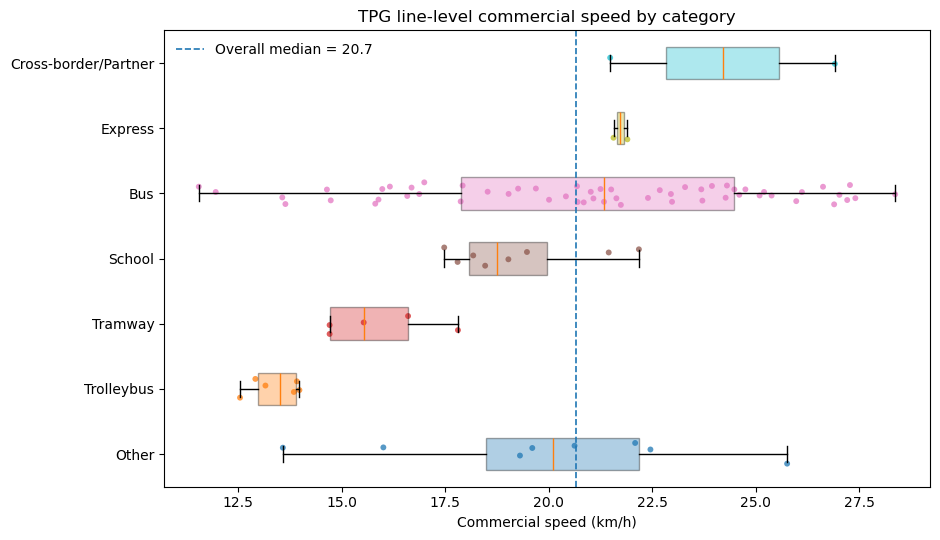

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Load CSV (robust to ; vs , delimiter)
# =========================
path = "../data/2026-01-13T06-51_export.csv"  # <-- change if needed

try:
    df = pd.read_csv(path)
except Exception:
    df = pd.read_csv(path, sep=";")

df.columns = df.columns.str.strip()

# =========================
# 2) Pick the commercial speed column
# =========================
cs_col = None
for c in df.columns:
    if c.lower().strip() in ["vitesse commerciale moy.", "vitesse commerciale moy", "vitesse commerciale"]:
        cs_col = c
        break
if cs_col is None:
    print("Available columns:", list(df.columns))
    raise ValueError("Could not find commercial-speed column. Check column names above.")

# =========================
# 3) Numeric cleaning (handles comma decimals)
# =========================
def to_float_series(s):
    s = s.astype(str).str.strip()
    s = s.str.replace("\u00a0", "", regex=False)   # non-breaking spaces
    s = s.str.replace(" ", "", regex=False)
    s = s.str.replace(",", ".", regex=False)      # decimal comma -> dot
    return pd.to_numeric(s, errors="coerce")

# =========================
# 4) Add TPG category (from https://www.tpg.ch/en/lignes)
# =========================
# Lists taken from the "Toutes nos lignes" section on tpg.ch  [oai_citation:1‡TPG](https://www.tpg.ch/en/lignes)
TRAM = {"12","14","15","17","18"}
TROLLEY = {"2","3","6","7","10","19"}
# Autobus list is long; keep it as a set so categorization is exact:
BUS = {
    "5","8","9","11","20","21","22","23","25","28","31","32","33","34","37","38","39","40","41","42","43","44",
    "45","46","47","48","50","51","52","53","54","55","57","59","60","61","64","66","67","68","69","70","71",
    "72","73","74","75","78","80","82","83","91","92","A","E","G","L"
}
EXPRESS = {"E+","G+"}
SCHOOL = {"C1","C3","C4","C5","C6","C7","C8","C9"}
CROSS_BORDER_PARTNERS = {"271","274","M","N"}

def norm_line_id(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    # make consistent: " 12 " -> "12"
    return s

def tpg_category(line_id: str) -> str:
    if not line_id:
        return "Unknown"
    if line_id in TRAM:
        return "Tramway"
    if line_id in TROLLEY:
        return "Trolleybus"
    if line_id in BUS:
        return "Bus"
    if line_id in EXPRESS:
        return "Express"
    if line_id in SCHOOL:
        return "School"
    if line_id in CROSS_BORDER_PARTNERS:
        return "Cross-border/Partner"

    return "Other"

# column name for line id (guess common options)
line_col = None
for c in df.columns:
    if c.lower().strip() in ["ligne", "line"]:
        line_col = c
        break
if line_col is None:
    print("Available columns:", list(df.columns))
    raise ValueError("Could not find the line column (expected 'Ligne').")

df["line_id"] = df[line_col].map(norm_line_id)
df["tpg_category"] = df["line_id"].map(tpg_category)

# =========================
# 5) Clean commercial speed + filter
# =========================
df["cs_kmh"] = to_float_series(df[cs_col])

# Optional: remove impossible values (edit bounds if needed)
df_plot = df.dropna(subset=["cs_kmh"]).copy()
df_plot = df_plot[(df_plot["cs_kmh"] > 0) & (df_plot["cs_kmh"] < 60)].copy()

print("Counts by category:")
print(df_plot["tpg_category"].value_counts(dropna=False))

# =========================
# 6) Plot: box + jitter points, colored by category
# =========================
# Order categories by median speed (nice for storytelling)
MED_ORDER = (
    df_plot.groupby("tpg_category")["cs_kmh"]
    .median()
    .sort_values()
)

tail_cats = ["Other", "Unknown"]  # put these at the end if they exist
cat_order = [c for c in tail_cats if c in MED_ORDER.index] + [c for c in MED_ORDER.index if c not in tail_cats]

# Prepare data arrays
data = [df_plot.loc[df_plot["tpg_category"] == cat, "cs_kmh"].to_numpy() for cat in cat_order]

fig, ax = plt.subplots(figsize=(9.5, 5.5))

bp = ax.boxplot(
    data,
    vert=False,
    labels=cat_order,
    patch_artist=True,
    showfliers=False,
)

# Color each category differently
cmap = plt.cm.get_cmap("tab10", len(cat_order))
for i, patch in enumerate(bp["boxes"]):
    patch.set_facecolor(cmap(i))
    patch.set_alpha(0.35)

# Jittered points (one dot per line)
rng = np.random.default_rng(42)
for i, cat in enumerate(cat_order, start=1):
    vals = df_plot.loc[df_plot["tpg_category"] == cat, "cs_kmh"].to_numpy()
    y = i + rng.uniform(-0.18, 0.18, size=len(vals))
    ax.scatter(vals, y, s=18, alpha=0.75, color=cmap(i-1), edgecolors="none")

ax.set_xlabel("Commercial speed (km/h)")
ax.set_title("TPG line-level commercial speed by category")

# Optional reference line(s)
ax.axvline(df_plot["cs_kmh"].median(), linestyle="--", linewidth=1.2, label=f"Overall median = {df_plot['cs_kmh'].median():.1f}")
ax.legend(frameon=False)

plt.tight_layout()

# Save for LaTeX
# fig.savefig("tpg_commercial_speed_by_category.pdf", bbox_inches="tight")
fig.savefig("../figure/tpg_commercial_speed_by_category.png", dpi=300, bbox_inches="tight")

plt.show()

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_30771/1621187123.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'serif' not found because none of the following families were found: serif
findfont: Generic family 'ser

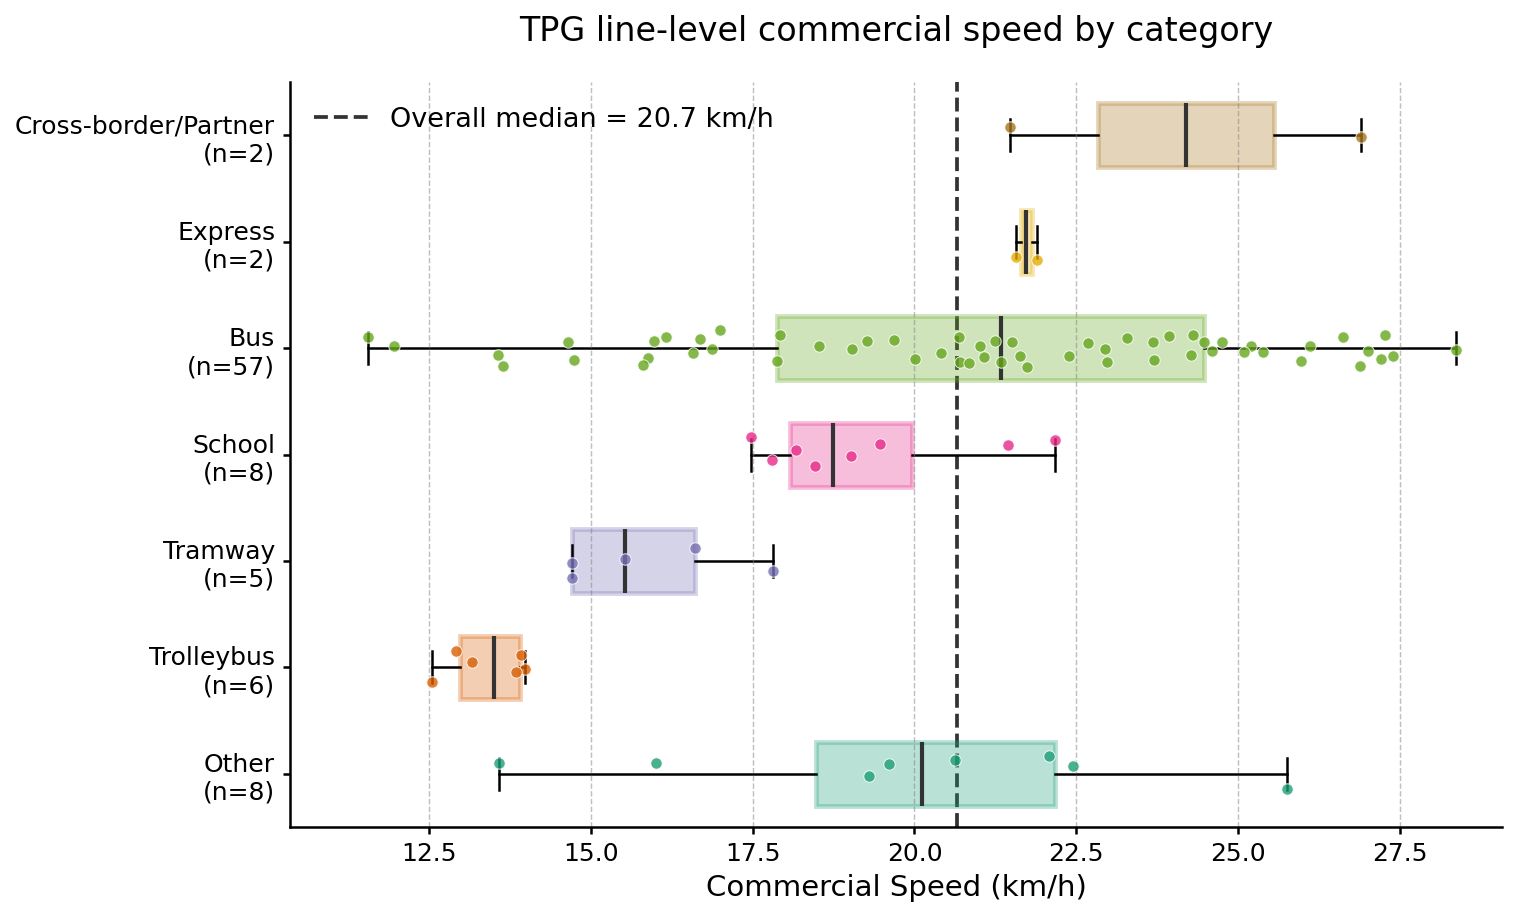

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. SCI-Style Configuration
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "lines.linewidth": 1.5,
    "legend.frameon": False,
    "legend.fontsize": 13,
})

# -------------------------
# 2. Data Preparation
# -------------------------
# (Assuming df_plot is loaded)
MED_ORDER = (
    df_plot.groupby("tpg_category")["cs_kmh"]
    .median()
    .sort_values()
)

tail_cats = ["Other", "Unknown"]
core = [c for c in MED_ORDER.index if c not in tail_cats]
tail = [c for c in tail_cats if c in MED_ORDER.index]
cat_order = tail + core 

# Labels with n
n_by_cat = df_plot["tpg_category"].value_counts()
labels = [f"{cat}\n(n={int(n_by_cat.get(cat, 0))})" for cat in cat_order]
data = [df_plot.loc[df_plot["tpg_category"] == cat, "cs_kmh"].to_numpy() for cat in cat_order]

# -------------------------
# 3. Plotting
# -------------------------
palette = plt.get_cmap("Dark2").colors
colors = [palette[i % len(palette)] for i in range(len(cat_order))]

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# Grid
ax.grid(axis="x", which="major", linestyle="--", linewidth=0.7, alpha=0.5, color="gray", zorder=0)

# Boxplots
bp = ax.boxplot(
    data,
    vert=False,
    labels=labels,
    patch_artist=True,
    showfliers=False,
    widths=0.6,
    zorder=1,
    medianprops=dict(color="#333333", linewidth=2.0, linestyle="-"),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
)

# Style boxes
for patch, col in zip(bp["boxes"], colors):
    patch.set_facecolor(col)
    patch.set_alpha(0.3)
    patch.set_edgecolor(col)
    patch.set_linewidth(2.3)

# Jitter points
rng = np.random.default_rng(42)
for i, (vals, col) in enumerate(zip(data, colors), start=1):
    y = i + rng.uniform(-0.18, 0.18, size=len(vals))
    ax.scatter(
        vals, y, 
        s=30, 
        alpha=0.8, 
        color=col, 
        edgecolors="white",
        linewidths=0.5, 
        zorder=2
    )

# -------------------------
# 4. Annotation & Title
# -------------------------
overall_med = float(df_plot["cs_kmh"].median())

ax.axvline(
    overall_med, 
    linestyle="--", 
    linewidth=1.8, 
    color="#333333", 
    zorder=0.5,
    label=f"Overall median = {overall_med:.1f} km/h"
)

ax.legend(loc="upper left")

# Title added here
ax.set_title("TPG line-level commercial speed by category", pad=20)

# -------------------------
# 5. Final Polish
# -------------------------
ax.set_xlabel("Commercial Speed (km/h)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

all_data = np.concatenate(data)
xmin, xmax = np.percentile(all_data, [1, 99])
pad = 0.1 * (xmax - xmin)
ax.set_xlim(xmin - pad, xmax + pad)

fig.savefig("../figure/tpg_commercial_speed_by_category.png", dpi=300, bbox_inches="tight")
plt.show()